# Interrogating BERT (Classification)

By Peter Usherwood, 

Adpated from the official tutorial found here https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb


# 0.0 Intro

BERT is currently one of (if not top of the) leaders in NLP transfer learning. To get a full picture on what BERT is I reccomend refering to the original paper https://arxiv.org/abs/1810.04805 or this excellent blog post on the NLP transfer learning zoo http://jalammar.github.io/illustrated-bert/. Here we going through a more technical user guide of how to do transfer learning with BERT. The target audience for this is data scientists who understand a bit of tensorflow/python/nlp/deep learning already.

This "tutorial" is split into 2 notebooks, this is the first where we shall see how BERT works by looking at doing a simple classification transfer learning task. However I have dedicated a whole second notebook to understanding how to use BERT for sequence to sequence tasks (specifically question answering with a Facebook dataset) because in my opinion it is such a maaaaaaaassive pain it needs a whole extra notebook. However I wont re-cover things in here in that one so please read both :)

The purpose of this notebook/tutorial is interrogate BERT to understand exactly what he is, how he works, and how we can use him. Here a lot of this notebook is based on the official tutorial for BERT, and we do use the official BERT library, however.... whenever the BERT library boilerplate is used to hide what is going on we pull it apart to understand exactly what is going on at each stage and how we 'could' modify it. The goal here is to give a comprehensive technical tutorial for transfer learning with BERT so that we can use it in the most project/data agnostic way possible, after we could go back to using boilerplate or not depending on our project. As such you will see the phrase 'BERT black box' used quite disparagingly here, however it is more used as a reference point for where were attempting to de-mistify the high level apis.

Now when I say comprehensive technical tutorial, I am still treating this from the transfer learning side, I am not here diving down into how the core net works, just fully understanding the inputs, how we join the core net into a bigger model, how we train and evaluate it, and how we can use all of that in a pipeline. 

I built this tutorial based on the great official one found here, if you just want a quick working example I reccomend reading that instead (this one's more wordy) https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

Now not all of the high level apis here are BERTs fault, and they may not even be vexing to you. Specifically Estimators and Tensorflow Hub are used extensively here. These are not super new but new enough that they were confusing to me, as such I will lightly tackle these at the same time, particularaly in places where the BERT black box overlaps so we fully appriciate whats going on.

- NOTE: Connecting to hub can be a problem on some Kantar networks, if the code in tokenizer or model hangs, take your laptop home and try there.
- NOTE: You need Tensorflow 1.11.0> for BERT
- NOTE: Unless you've got a nice graphics card, probably its best to upload this and the data to colab and run it there
- NOTE: it is important to remember BERT is not a person when you read this notebook

# 0.1 How fat is BERT?

This is a key question, it's all well and good understanding the thoery or the technical detail but if we cant run BERT on are hardware it's not much good. So how fat is he? Well unfortunately... quite. As said on the official github repo:

"Important: All results on the paper were fine-tuned on a single Cloud TPU, which has 64GB of RAM. It is currently not possible to re-produce most of the BERT-Large results on the paper using a GPU with 12GB - 16GB of RAM, because the maximum batch size that can fit in memory is too small. We are working on adding code to this repository which allows for much larger effective batch size on the GPU. See the section on out-of-memory issues for more details.

This code was tested with TensorFlow 1.11.0. It was tested with Python2 and Python3 (but more thoroughly with Python2, since this is what's used internally in Google).

The fine-tuning examples which use BERT-Base should be able to run on a GPU that has at least 12GB of RAM using the hyperparameters given."

To put this in perspective most mid-range laptops with GPUs will have about 4GB VRAM (as per mine). And the best "reasonable" consumer graphics card you'd buy is the RTX 2080Ti which has 11GB and costs like $1200 (if you live in the US, where I am its like 2000). Now google colab do allow you to have up to I think its about 12GB VRAM so you can run BERT-small there (which is what im doing in this tutorial), but its important to bare this in mind when making producing classifiers with BERT.

# 0.2 How fast is BERT?

So to train the base language model in BERT is quite slow, as expected its a huge transformer neural net that runs forward and back passes and does next sentence prediction. As per the published paper:

"Training of BERTBASE was performed on 4
Cloud TPUs in Pod configuration (16 TPU chips
total).5 Training of BERTLARGE was performed
on 16 Cloud TPUs (64 TPU chips total). Each pretraining took 4 days to complete."

However thats not really the focus of this tutorial (although something to bare in mind if you were thinking of training a BERT in a different language). Here we're focusing more on transfer learning using a pre-trained BERT and the good news here is it is quite fast. Training the classification example here with 1500 labeled examples only takes of the order 5-10 minutes, and this should scale linearly with number of examples (you could obviously up the number of epochs too). So in conclusion once you have the base, BERT is quite fast, if you have a graphics card that can hold him training time is not an issue.

# 0.3 How good is BERT at school?

Anybody thats been following NLP knows BERT got SOTAs across the board on various language tasks, one thing of particular interest is that the architecture allows for seq -> seq tasks as well as classification which makes it more felixble than some of the others (ULMFiT for example). One thing that is not fully clear to me yet is how good BERT (or indeed other transfer learning techniques) are when put under "extreme" conditions, for example low shot learning, dirty or noisy text data like social, how good they are going cross domain etc. Im looking into this, but thats for another time, all that is important for now is, it seems BERT is one of the best at NLP ML problems today.

# 0.4 How do we make him dance?

This is the main purpose of this repo, its understanding how BERT works and how we can use it to build out useful classifiers and seq -> seq tasks. As per the official tutorial we start by looking at a classification problem (this notebook), although here we use trinary data and not binary and a different dataset (Yelp) to ensure things are agnostic as possible. After we will look at seq -> seq for contextual question answering (in the second notebook)

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub # pip install tensorflow-hub
from datetime import datetime

In [2]:
!pip install bert-tensorflow
import bert # pip install bert-tensorflow
from bert import run_classifier
from bert import optimization
from bert import tokenization

     |████████████████████████████████| 71kB 2.8MB/s 


W0730 14:22:17.520803 140708289415040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [3]:
# Only run this if your doing this on colab, you will have to upload the data to drive too
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1.0 Data

First we get some data, nothing here is BERT specific, just getting any old classification data, this comes from Yelp and has been balanced and only 1, 3, and 5 star reviews are included

In [0]:
df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/train.csv")
df_val = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/validate.csv")
df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/yelp/balanced/test.csv")

FileNotFoundError: ignored

Make sure we shuffle the data here or BERT fails

In [0]:
df_trn = df_trn[["text", "label"]]
df_tst = df_tst[["text", "label"]]

df_trn = df_trn.sample(frac=1)
df_tst = df_tst.sample(frac=1)

df_trn.sample(n=10)

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [1, 3, 5]

# 2.0 Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves three steps:
- First, we create  `InputExample`'s using the constructor provided in the BERT library.
- Second, we load the model specific tokenizer
- Third, we convert examples to features BERT understands using parts 1 and 2

# 2.1 Input Features

These classes are super simple and litterally just have 4 attributes that hold the text. What info they hold is listed below.


- `text_a` is the text we want to classify, which in this case, is the `text` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [0]:
train_InputExamples = df_trn.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = df_tst.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

NameError: ignored

## Understanding what BERT eats

Now this is an ok explination to operate BERT basically, but if we want to really understand what is going inside we need to fully approciate theoretically what BERT wants for its inputs (this part is key for lots of later discussion to). And BERTs input representation is not intuitive (in my opinion).

First we can mention how it wants its inputs ordered. 

It can take up to 512 tokens in a single 'sequence'. A sequence is defined as one input example (however that may be constructed). Note this limit on 512 is actually very important when we come to look at question answering.

Said sequence is composed in one of two ways as best described by comments in the oficial repo...

The convention in BERT is:

(a) For sequence pairs:

tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]

(b) For single sequences:

tokens:   [CLS] the dog is hairy . [SEP]

So depending on if we're doing single sequence or sequence to sequence we arrange the data in one of these two ways. Note BERT refer to the whole input as the sequence, and each of the two potential parts as sentences even though they can be longer or shorter than a linguistic sentence.

Next we have to understand what BERT does with these words, goes to word embeddings? We'll yes but not so simply...

![image.png](attachment:image.png)

BERT actually sums 3 different embeddings, however as we shall see we only actually need to create the ids for the word embeddings and the segment embeddings as inputs to the model. Creating the positional embeddings, gettings the vectors, and summing is all done internally, and in this notebook we're not messing with core BERT.

# 2.1 Tokenizer

Next, we need to preprocess our data so that it matches the data BERT was trained on.This follows the following process.


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Now the original blog says "Happily, we don't have to worry about most of these details.", and simply instanciates an instance of the bert.tokenization.FullTokenizer class... but I want to go deeper.

So lets look at BERTs tokenizer setup:

```
######################### SOURCE CODE ###############################
class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)
######################### SOURCE CODE ###############################
```

This above code is taken directly from their repository, as we can see the tokenizer has all the basic components we'd expect. 

- vocab is a dictionary that maps ids to words in the input vocab (familiar to anyone acustomed to working with language models)
- inv_vocab is the oposite, words to ids
- they then have two tokenizers, one is a more basic form and the other splits out word parts, they could have grouped the two

Now this is simple enoguh, however the "recomended" way of instanciating this is (to me) super confusing!!! (See below)

In [4]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


"""Get the vocab file and casing info from the Hub module."""
with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        
tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                            do_lower_case=do_lower_case)

W0730 14:27:07.960558 140708289415040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [5]:

f = open(vocab_file, "r")
print(len(f.read()))

228209


So... what happened?

Well here we are using Tensorflow Hub, which is Tensorflows newest way of easily sharing pre-trained models, its vital to understand this for anyone doing transfer learning in TF. The BERT model was loaded in the deafult graph (standard Tensorflow) from Hub https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1 by calling a set filepath into hub.Module. As such to go any further we really need to understand exactly what the hub.Module returns, and how we get at the underlying module. To start the official docs https://www.tensorflow.org/hub/api_docs/python/hub/Module are actually quite good on Module.__init__:

######################### OFFICIAL DOCS ###############################

Constructs a Module to be used in the current graph.

This creates the module state-graph under an unused variable_scope based on name. During this call a Module will:

Add GLOBAL_VARIABLES under its scope. Those variables may be added to to the TRAINABLE_VARIABLES collection (depending on trainable parameter) and to the MODEL_VARIABLES. The variables must be initialized before use, and can be checkpointed as usual.

Add ops to the INIT_TABLE_OPS collection, which must be run during session initialization and add constant tensors to ASSET_FILEPATHS that are needed during the execution of such ops.

Add tensors to the REGULARIZATION_LOSSES collection (depending on trainable parameter).

Args:
- spec: A ModuleSpec defining the Module to instantiate or a path where to load a ModuleSpec from via load_module_spec.
- trainable: whether the Module is trainable. If False, no variables are added to TRAINABLE_VARIABLES collection, and no tensors are added to REGULARIZATION_LOSSES collection.
- name: A string, the variable scope name under which to create the Module. It will be uniquified and the equivalent name scope must be unused.
- tags: A set of strings specifying the graph variant to use.

######################### OFFICIAL DOCS ###############################

Thats reasonably clear (for tensorflow) we now have all of the variables of the BERT graph defined under a specific variable scope. It also added these to some dictionaries of what variables exist (for example trainable parameters). Finally it adds the operations to the INIT_TABLE_OPS.

So now I have at least 3 questions (maybe inquisitive you has many more :))... 
- How do we access the variables? Can we modify the graph? 
- How do we call it? In what way is it being called?
- What in the world are these next 3 lines!?!?

    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    
    with tf.Session() as sess:
    
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
                                            
To help with these im drawing a lot of inspiration from this tutorial that you should definetly check out https://medium.com/ymedialabs-innovation/how-to-use-tensorflow-hub-with-code-examples-9100edec29af.

So to start with once we have the instance it is called using a 'signature'. Whats a signature? Well the signatures are pre-defined use cases for how the creator wants the user to call their model. We can see the available signatures by running:

In [0]:
bert_module.get_signature_names()

['tokens', 'tokenization_info', 'mlm']

Well now we have these abstracted use cases, but what do we need to give to them? And what do they output? As is the case with BERT this is documented on tf hub, they only actually support the 'tokens' signature... (even though we're using the tokenization_info one here...), however we can check by running:

In [0]:
print(bert_module.get_input_info_dict(signature='tokens'))
print(bert_module.get_output_info_dict(signature='tokens'))

print(bert_module.get_input_info_dict(signature='tokenization_info'))
print(bert_module.get_output_info_dict(signature='tokenization_info'))

{'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}
{'sequence_output': <hub.ParsedTensorInfo shape=(?, ?, 768) dtype=float32 is_sparse=False>, 'pooled_output': <hub.ParsedTensorInfo shape=(?, 768) dtype=float32 is_sparse=False>}
{}
{'do_lower_case': <hub.ParsedTensorInfo shape=() dtype=bool is_sparse=False>, 'vocab_file': <hub.ParsedTensorInfo shape=() dtype=string is_sparse=False>}


So given what we know about what BERT eats and the output we'd expect from a language model, 'tokens' seems to make sense in what it does, that is the main running process. However thats section 3. Here lets look more at 'tokenization_info', 'tokenization_info' doesnt take any inputs (makes sense as the tokenization should depend only on the model and not on the inputs), and gives two outputs: the vocab file and if we should lower everything... makes sense.

Now this business makes sense:
```
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
with tf.Session() as sess:
    vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                        tokenization_info["do_lower_case"]])
```                                           
As tokenization_info (the variable) here is a pointer to two tensors in the graph, each of which are called and their output returned, noramlly in session.run we'd pass the input as well but we already know for these specific endpoints there are no inputs. Now session.run will run the pretrained graph and these two endpoints will give us what we need.

I havn't addressed the accessing and messing with the main graph yet, I think that makes more sense in the model section where as it turns out we need to reload the model from tf hub in the same way, so for now we'll continue just knowning how to call the model and what it returns.

So back to the original tutorial... "we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:"

In [0]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer!")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer',
 '!']

In [0]:
#tokenizer.vocab["U1f600"]

KeyError: ignored

Now to add a bit of "whats going on" we can easily parse the vocab attribute (that we saw earlier as part of the tokenizer) to a pandas df to view the vocabulary

In [0]:
vocab_df = pd.DataFrame(np.array([list(tokenizer.vocab.keys()), list(tokenizer.vocab.values())]).T, columns=["Vocab", "ID"])
vocab_df.sample(n=10)

,Vocab,ID
24477,bolshevik,24477
8028,renaissance,8028
26132,##vez,26132
24048,tnt,24048
15190,torso,15190
21443,peanut,21443
16075,mccoy,16075
14078,132,14078
28145,kunst,28145
27650,ported,27650


In [0]:
len(bert_module.variable_map)
tokenization_info['do_lower_case']

<tf.Tensor 'module_apply_tokenization_info/Const:0' shape=() dtype=bool>

# 2.3 Examples to Features

Next.... Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands. Now we know that BERT is hoping for inputs of the form:

In [0]:
print(bert_module.get_input_info_dict(signature='tokens'))

{'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}


But as is this is completely black box as to what is happening here! Let's look

In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1572


I0430 17:48:05.400015 139837559089024 run_classifier.py:774] Writing example 0 of 1572


INFO:tensorflow:*** Example ***


I0430 17:48:05.404440 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:05.407813 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this location was a group ##on find . . . won ' t be back . the girl behind the counter was nice but even though i had the group ##on right in front of me , she had to read it several times and i had to explain to her what i was supposed to be getting with it . the red light therapy is a nice idea . . . but the room the bed was in was lacking . they should hire an ex ##ter ##mina ##tor , not leave sticky bug traps down with dead bugs all over the floor where people generally have bare feet . . . yu ##ck ! ! [SEP]


I0430 17:48:05.410256 139837559089024 run_classifier.py:464] tokens: [CLS] this location was a group ##on find . . . won ' t be back . the girl behind the counter was nice but even though i had the group ##on right in front of me , she had to read it several times and i had to explain to her what i was supposed to be getting with it . the red light therapy is a nice idea . . . but the room the bed was in was lacking . they should hire an ex ##ter ##mina ##tor , not leave sticky bug traps down with dead bugs all over the floor where people generally have bare feet . . . yu ##ck ! ! [SEP]


INFO:tensorflow:input_ids: 101 2023 3295 2001 1037 2177 2239 2424 1012 1012 1012 2180 1005 1056 2022 2067 1012 1996 2611 2369 1996 4675 2001 3835 2021 2130 2295 1045 2018 1996 2177 2239 2157 1999 2392 1997 2033 1010 2016 2018 2000 3191 2009 2195 2335 1998 1045 2018 2000 4863 2000 2014 2054 1045 2001 4011 2000 2022 2893 2007 2009 1012 1996 2417 2422 7242 2003 1037 3835 2801 1012 1012 1012 2021 1996 2282 1996 2793 2001 1999 2001 11158 1012 2027 2323 10887 2019 4654 3334 22311 4263 1010 2025 2681 15875 11829 16735 2091 2007 2757 12883 2035 2058 1996 2723 2073 2111 3227 2031 6436 2519 1012 1012 1012 9805 3600 999 999 102 0 0 0 0 0 0 0 0 0


I0430 17:48:05.411423 139837559089024 run_classifier.py:465] input_ids: 101 2023 3295 2001 1037 2177 2239 2424 1012 1012 1012 2180 1005 1056 2022 2067 1012 1996 2611 2369 1996 4675 2001 3835 2021 2130 2295 1045 2018 1996 2177 2239 2157 1999 2392 1997 2033 1010 2016 2018 2000 3191 2009 2195 2335 1998 1045 2018 2000 4863 2000 2014 2054 1045 2001 4011 2000 2022 2893 2007 2009 1012 1996 2417 2422 7242 2003 1037 3835 2801 1012 1012 1012 2021 1996 2282 1996 2793 2001 1999 2001 11158 1012 2027 2323 10887 2019 4654 3334 22311 4263 1010 2025 2681 15875 11829 16735 2091 2007 2757 12883 2035 2058 1996 2723 2073 2111 3227 2031 6436 2519 1012 1012 1012 9805 3600 999 999 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


I0430 17:48:05.414112 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.416495 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0430 17:48:05.417809 139837559089024 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0430 17:48:05.419634 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:05.420932 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] good , but the salad was not as good as remembered . still think its a great spot in sc ##oot ##sdale ! [SEP]


I0430 17:48:05.422178 139837559089024 run_classifier.py:464] tokens: [CLS] good , but the salad was not as good as remembered . still think its a great spot in sc ##oot ##sdale ! [SEP]


INFO:tensorflow:input_ids: 101 2204 1010 2021 1996 16521 2001 2025 2004 2204 2004 4622 1012 2145 2228 2049 1037 2307 3962 1999 8040 17206 15145 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.423602 139837559089024 run_classifier.py:465] input_ids: 101 2204 1010 2021 1996 16521 2001 2025 2004 2204 2004 4622 1012 2145 2228 2049 1037 2307 3962 1999 8040 17206 15145 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.424867 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.426008 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


I0430 17:48:05.427166 139837559089024 run_classifier.py:468] label: 3 (id = 1)


INFO:tensorflow:*** Example ***


I0430 17:48:05.431373 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:05.432664 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] this review can be applied to any and all quick trip locations . i have , on many occasions , gone out of my way to stop in q ##t over other gas stations , because not only are they much much nice ##r , but they are very clean and offer a ton of gas station fare ( drinks , shakes , coffee ##s , juice ##s , snacks , etc ) . i really appreciate how quickly they work , with cash ##ier ' s that are able to take care of two customers at once . i usually ab ##hor using gas station bathrooms because , let ' s face it , we ' ve all been there and seen how put ##rid [SEP]


I0430 17:48:05.433958 139837559089024 run_classifier.py:464] tokens: [CLS] this review can be applied to any and all quick trip locations . i have , on many occasions , gone out of my way to stop in q ##t over other gas stations , because not only are they much much nice ##r , but they are very clean and offer a ton of gas station fare ( drinks , shakes , coffee ##s , juice ##s , snacks , etc ) . i really appreciate how quickly they work , with cash ##ier ' s that are able to take care of two customers at once . i usually ab ##hor using gas station bathrooms because , let ' s face it , we ' ve all been there and seen how put ##rid [SEP]


INFO:tensorflow:input_ids: 101 2023 3319 2064 2022 4162 2000 2151 1998 2035 4248 4440 5269 1012 1045 2031 1010 2006 2116 6642 1010 2908 2041 1997 2026 2126 2000 2644 1999 1053 2102 2058 2060 3806 3703 1010 2138 2025 2069 2024 2027 2172 2172 3835 2099 1010 2021 2027 2024 2200 4550 1998 3749 1037 10228 1997 3806 2276 13258 1006 8974 1010 10854 1010 4157 2015 1010 10869 2015 1010 27962 1010 4385 1007 1012 1045 2428 9120 2129 2855 2027 2147 1010 2007 5356 3771 1005 1055 2008 2024 2583 2000 2202 2729 1997 2048 6304 2012 2320 1012 1045 2788 11113 16368 2478 3806 2276 28942 2138 1010 2292 1005 1055 2227 2009 1010 2057 1005 2310 2035 2042 2045 1998 2464 2129 2404 14615 102


I0430 17:48:05.435210 139837559089024 run_classifier.py:465] input_ids: 101 2023 3319 2064 2022 4162 2000 2151 1998 2035 4248 4440 5269 1012 1045 2031 1010 2006 2116 6642 1010 2908 2041 1997 2026 2126 2000 2644 1999 1053 2102 2058 2060 3806 3703 1010 2138 2025 2069 2024 2027 2172 2172 3835 2099 1010 2021 2027 2024 2200 4550 1998 3749 1037 10228 1997 3806 2276 13258 1006 8974 1010 10854 1010 4157 2015 1010 10869 2015 1010 27962 1010 4385 1007 1012 1045 2428 9120 2129 2855 2027 2147 1010 2007 5356 3771 1005 1055 2008 2024 2583 2000 2202 2729 1997 2048 6304 2012 2320 1012 1045 2788 11113 16368 2478 3806 2276 28942 2138 1010 2292 1005 1055 2227 2009 1010 2057 1005 2310 2035 2042 2045 1998 2464 2129 2404 14615 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0430 17:48:05.436494 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.437804 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 2)


I0430 17:48:05.439043 139837559089024 run_classifier.py:468] label: 5 (id = 2)


INFO:tensorflow:*** Example ***


I0430 17:48:05.449503 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:05.450787 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i don ' t know why i waited so long to try this place when it is literally right around the corner from my house . i think its because i went to the one in ah ##wat ##uke ##e a long time ago and didn ' t care for the food . but i don ' t think they have the same owners since the websites are totally different . but anyway , on to the review . we ordered take ##out and i was very impressed with how nicely it was all packaged and how quickly it was ready . also , the woman on the phone was very friendly , easy to understand in spite of an accent , and patient in explaining [SEP]


I0430 17:48:05.452197 139837559089024 run_classifier.py:464] tokens: [CLS] i don ' t know why i waited so long to try this place when it is literally right around the corner from my house . i think its because i went to the one in ah ##wat ##uke ##e a long time ago and didn ' t care for the food . but i don ' t think they have the same owners since the websites are totally different . but anyway , on to the review . we ordered take ##out and i was very impressed with how nicely it was all packaged and how quickly it was ready . also , the woman on the phone was very friendly , easy to understand in spite of an accent , and patient in explaining [SEP]


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 2113 2339 1045 4741 2061 2146 2000 3046 2023 2173 2043 2009 2003 6719 2157 2105 1996 3420 2013 2026 2160 1012 1045 2228 2049 2138 1045 2253 2000 1996 2028 1999 6289 24281 15851 2063 1037 2146 2051 3283 1998 2134 1005 1056 2729 2005 1996 2833 1012 2021 1045 2123 1005 1056 2228 2027 2031 1996 2168 5608 2144 1996 11744 2024 6135 2367 1012 2021 4312 1010 2006 2000 1996 3319 1012 2057 3641 2202 5833 1998 1045 2001 2200 7622 2007 2129 19957 2009 2001 2035 21972 1998 2129 2855 2009 2001 3201 1012 2036 1010 1996 2450 2006 1996 3042 2001 2200 5379 1010 3733 2000 3305 1999 8741 1997 2019 9669 1010 1998 5776 1999 9990 102


I0430 17:48:05.453476 139837559089024 run_classifier.py:465] input_ids: 101 1045 2123 1005 1056 2113 2339 1045 4741 2061 2146 2000 3046 2023 2173 2043 2009 2003 6719 2157 2105 1996 3420 2013 2026 2160 1012 1045 2228 2049 2138 1045 2253 2000 1996 2028 1999 6289 24281 15851 2063 1037 2146 2051 3283 1998 2134 1005 1056 2729 2005 1996 2833 1012 2021 1045 2123 1005 1056 2228 2027 2031 1996 2168 5608 2144 1996 11744 2024 6135 2367 1012 2021 4312 1010 2006 2000 1996 3319 1012 2057 3641 2202 5833 1998 1045 2001 2200 7622 2007 2129 19957 2009 2001 2035 21972 1998 2129 2855 2009 2001 3201 1012 2036 1010 1996 2450 2006 1996 3042 2001 2200 5379 1010 3733 2000 3305 1999 8741 1997 2019 9669 1010 1998 5776 1999 9990 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0430 17:48:05.454800 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.456113 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


I0430 17:48:05.457401 139837559089024 run_classifier.py:468] label: 3 (id = 1)


INFO:tensorflow:*** Example ***


I0430 17:48:05.461480 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:05.462778 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] we used the ta ##co cart for my 30th birthday this past weekend and we came away very impressed . eduardo was the guy that came to our fiesta , and he was incredible . when he arrived , we experienced a ha ##bo ##ob and he immediately stepped in and helped bring in our decorations and furniture . he waited about 30 minutes until serving because we were unsure if the ha ##bo ##ob was going to attack again . my wife and i are both in the restaurant bi ##z and so were many of the guests , we all came away impressed with the food quality . next time we throw a party , we will use them again ! make sure to [SEP]


I0430 17:48:05.464303 139837559089024 run_classifier.py:464] tokens: [CLS] we used the ta ##co cart for my 30th birthday this past weekend and we came away very impressed . eduardo was the guy that came to our fiesta , and he was incredible . when he arrived , we experienced a ha ##bo ##ob and he immediately stepped in and helped bring in our decorations and furniture . he waited about 30 minutes until serving because we were unsure if the ha ##bo ##ob was going to attack again . my wife and i are both in the restaurant bi ##z and so were many of the guests , we all came away impressed with the food quality . next time we throw a party , we will use them again ! make sure to [SEP]


INFO:tensorflow:input_ids: 101 2057 2109 1996 11937 3597 11122 2005 2026 13293 5798 2023 2627 5353 1998 2057 2234 2185 2200 7622 1012 14846 2001 1996 3124 2008 2234 2000 2256 24050 1010 1998 2002 2001 9788 1012 2043 2002 3369 1010 2057 5281 1037 5292 5092 16429 1998 2002 3202 3706 1999 1998 3271 3288 1999 2256 14529 1998 7390 1012 2002 4741 2055 2382 2781 2127 3529 2138 2057 2020 12422 2065 1996 5292 5092 16429 2001 2183 2000 2886 2153 1012 2026 2564 1998 1045 2024 2119 1999 1996 4825 12170 2480 1998 2061 2020 2116 1997 1996 6368 1010 2057 2035 2234 2185 7622 2007 1996 2833 3737 1012 2279 2051 2057 5466 1037 2283 1010 2057 2097 2224 2068 2153 999 2191 2469 2000 102


I0430 17:48:05.465621 139837559089024 run_classifier.py:465] input_ids: 101 2057 2109 1996 11937 3597 11122 2005 2026 13293 5798 2023 2627 5353 1998 2057 2234 2185 2200 7622 1012 14846 2001 1996 3124 2008 2234 2000 2256 24050 1010 1998 2002 2001 9788 1012 2043 2002 3369 1010 2057 5281 1037 5292 5092 16429 1998 2002 3202 3706 1999 1998 3271 3288 1999 2256 14529 1998 7390 1012 2002 4741 2055 2382 2781 2127 3529 2138 2057 2020 12422 2065 1996 5292 5092 16429 2001 2183 2000 2886 2153 1012 2026 2564 1998 1045 2024 2119 1999 1996 4825 12170 2480 1998 2061 2020 2116 1997 1996 6368 1010 2057 2035 2234 2185 7622 2007 1996 2833 3737 1012 2279 2051 2057 5466 1037 2283 1010 2057 2097 2224 2068 2153 999 2191 2469 2000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0430 17:48:05.466933 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:05.468225 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 2)


I0430 17:48:05.469425 139837559089024 run_classifier.py:468] label: 5 (id = 2)


INFO:tensorflow:Writing example 0 of 450


I0430 17:48:09.604889 139837559089024 run_classifier.py:774] Writing example 0 of 450


INFO:tensorflow:*** Example ***


I0430 17:48:09.621703 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:09.624737 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] i would give this place no stars but ye ##lp ! wants me to give at least one . i went here with my boyfriend last night for dinner and next to our awful bu ##cca di be ##pp ##o ( scott ##sdale ) experience , i have to say , this one is on my list of most terrible restaurant experiences . the service was so bad , we didn ' t even get to try the food ! true ye ##lp ##er that i am , i did my homework before suggesting that we come here for dinner . i saw all the reviews about the " bad service " , but i paid more attention to the " cheap " and " delicious [SEP]


I0430 17:48:09.628988 139837559089024 run_classifier.py:464] tokens: [CLS] i would give this place no stars but ye ##lp ! wants me to give at least one . i went here with my boyfriend last night for dinner and next to our awful bu ##cca di be ##pp ##o ( scott ##sdale ) experience , i have to say , this one is on my list of most terrible restaurant experiences . the service was so bad , we didn ' t even get to try the food ! true ye ##lp ##er that i am , i did my homework before suggesting that we come here for dinner . i saw all the reviews about the " bad service " , but i paid more attention to the " cheap " and " delicious [SEP]


INFO:tensorflow:input_ids: 101 1045 2052 2507 2023 2173 2053 3340 2021 6300 14277 999 4122 2033 2000 2507 2012 2560 2028 1012 1045 2253 2182 2007 2026 6898 2197 2305 2005 4596 1998 2279 2000 2256 9643 20934 16665 4487 2022 9397 2080 1006 3660 15145 1007 3325 1010 1045 2031 2000 2360 1010 2023 2028 2003 2006 2026 2862 1997 2087 6659 4825 6322 1012 1996 2326 2001 2061 2919 1010 2057 2134 1005 1056 2130 2131 2000 3046 1996 2833 999 2995 6300 14277 2121 2008 1045 2572 1010 1045 2106 2026 19453 2077 9104 2008 2057 2272 2182 2005 4596 1012 1045 2387 2035 1996 4391 2055 1996 1000 2919 2326 1000 1010 2021 1045 3825 2062 3086 2000 1996 1000 10036 1000 1998 1000 12090 102


I0430 17:48:09.631678 139837559089024 run_classifier.py:465] input_ids: 101 1045 2052 2507 2023 2173 2053 3340 2021 6300 14277 999 4122 2033 2000 2507 2012 2560 2028 1012 1045 2253 2182 2007 2026 6898 2197 2305 2005 4596 1998 2279 2000 2256 9643 20934 16665 4487 2022 9397 2080 1006 3660 15145 1007 3325 1010 1045 2031 2000 2360 1010 2023 2028 2003 2006 2026 2862 1997 2087 6659 4825 6322 1012 1996 2326 2001 2061 2919 1010 2057 2134 1005 1056 2130 2131 2000 3046 1996 2833 999 2995 6300 14277 2121 2008 1045 2572 1010 1045 2106 2026 19453 2077 9104 2008 2057 2272 2182 2005 4596 1012 1045 2387 2035 1996 4391 2055 1996 1000 2919 2326 1000 1010 2021 1045 3825 2062 3086 2000 1996 1000 10036 1000 1998 1000 12090 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0430 17:48:09.634519 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.638449 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0430 17:48:09.640321 139837559089024 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0430 17:48:09.645343 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:09.647080 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the staff at this location was rude and un ##fr ##ien ##dly ! ! also the store itself was not the clean ##est i have seen ! [SEP]


I0430 17:48:09.649372 139837559089024 run_classifier.py:464] tokens: [CLS] the staff at this location was rude and un ##fr ##ien ##dly ! ! also the store itself was not the clean ##est i have seen ! [SEP]


INFO:tensorflow:input_ids: 101 1996 3095 2012 2023 3295 2001 12726 1998 4895 19699 9013 18718 999 999 2036 1996 3573 2993 2001 2025 1996 4550 4355 1045 2031 2464 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.652951 139837559089024 run_classifier.py:465] input_ids: 101 1996 3095 2012 2023 3295 2001 12726 1998 4895 19699 9013 18718 999 999 2036 1996 3573 2993 2001 2025 1996 4550 4355 1045 2031 2464 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.655839 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.661016 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0430 17:48:09.663416 139837559089024 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0430 17:48:09.667406 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:09.672076 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] can ##t go wrong with a double double , fries , and a shake ! always good . great service . i got some cold fries once , called the corporate office , they sent out some gift cards for our meals , then followed up with a thank you card as well . not to mention they sent a coup ##on in a x ##mas card that year . you [SEP]


I0430 17:48:09.673922 139837559089024 run_classifier.py:464] tokens: [CLS] can ##t go wrong with a double double , fries , and a shake ! always good . great service . i got some cold fries once , called the corporate office , they sent out some gift cards for our meals , then followed up with a thank you card as well . not to mention they sent a coup ##on in a x ##mas card that year . you [SEP]


INFO:tensorflow:input_ids: 101 2064 2102 2175 3308 2007 1037 3313 3313 1010 22201 1010 1998 1037 6073 999 2467 2204 1012 2307 2326 1012 1045 2288 2070 3147 22201 2320 1010 2170 1996 5971 2436 1010 2027 2741 2041 2070 5592 5329 2005 2256 12278 1010 2059 2628 2039 2007 1037 4067 2017 4003 2004 2092 1012 2025 2000 5254 2027 2741 1037 8648 2239 1999 1037 1060 9335 4003 2008 2095 1012 2017 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.676099 139837559089024 run_classifier.py:465] input_ids: 101 2064 2102 2175 3308 2007 1037 3313 3313 1010 22201 1010 1998 1037 6073 999 2467 2204 1012 2307 2326 1012 1045 2288 2070 3147 22201 2320 1010 2170 1996 5971 2436 1010 2027 2741 2041 2070 5592 5329 2005 2256 12278 1010 2059 2628 2039 2007 1037 4067 2017 4003 2004 2092 1012 2025 2000 5254 2027 2741 1037 8648 2239 1999 1037 1060 9335 4003 2008 2095 1012 2017 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.678956 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.683132 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 2)


I0430 17:48:09.686676 139837559089024 run_classifier.py:468] label: 5 (id = 2)


INFO:tensorflow:*** Example ***


I0430 17:48:09.705815 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:09.708166 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] great in its day , now leaves a lot to be desired . deserves credit as a phoenix landmark chinese restaurant . this restaurant has been here for 38 years . i ' ve been going here off and on for 35 years . i go here more for sentimental reasons , and not so much for the food . the interior still retains some of the original decoration style from the original restaurant established nearly 40 years ago . the rest of the decorations have been torn out . i believe the decor is modeled after the forbidden palace in beijing - see the vault - of - the - heavens style cr ##ene ##lation ##s in the ceiling . i have this restaurant - [SEP]


I0430 17:48:09.712335 139837559089024 run_classifier.py:464] tokens: [CLS] great in its day , now leaves a lot to be desired . deserves credit as a phoenix landmark chinese restaurant . this restaurant has been here for 38 years . i ' ve been going here off and on for 35 years . i go here more for sentimental reasons , and not so much for the food . the interior still retains some of the original decoration style from the original restaurant established nearly 40 years ago . the rest of the decorations have been torn out . i believe the decor is modeled after the forbidden palace in beijing - see the vault - of - the - heavens style cr ##ene ##lation ##s in the ceiling . i have this restaurant - [SEP]


INFO:tensorflow:input_ids: 101 2307 1999 2049 2154 1010 2085 3727 1037 2843 2000 2022 9059 1012 17210 4923 2004 1037 6708 8637 2822 4825 1012 2023 4825 2038 2042 2182 2005 4229 2086 1012 1045 1005 2310 2042 2183 2182 2125 1998 2006 2005 3486 2086 1012 1045 2175 2182 2062 2005 23069 4436 1010 1998 2025 2061 2172 2005 1996 2833 1012 1996 4592 2145 14567 2070 1997 1996 2434 11446 2806 2013 1996 2434 4825 2511 3053 2871 2086 3283 1012 1996 2717 1997 1996 14529 2031 2042 7950 2041 1012 1045 2903 1996 25545 2003 14440 2044 1996 10386 4186 1999 7211 1011 2156 1996 11632 1011 1997 1011 1996 1011 17223 2806 13675 8625 13490 2015 1999 1996 5894 1012 1045 2031 2023 4825 1011 102


I0430 17:48:09.716689 139837559089024 run_classifier.py:465] input_ids: 101 2307 1999 2049 2154 1010 2085 3727 1037 2843 2000 2022 9059 1012 17210 4923 2004 1037 6708 8637 2822 4825 1012 2023 4825 2038 2042 2182 2005 4229 2086 1012 1045 1005 2310 2042 2183 2182 2125 1998 2006 2005 3486 2086 1012 1045 2175 2182 2062 2005 23069 4436 1010 1998 2025 2061 2172 2005 1996 2833 1012 1996 4592 2145 14567 2070 1997 1996 2434 11446 2806 2013 1996 2434 4825 2511 3053 2871 2086 3283 1012 1996 2717 1997 1996 14529 2031 2042 7950 2041 1012 1045 2903 1996 25545 2003 14440 2044 1996 10386 4186 1999 7211 1011 2156 1996 11632 1011 1997 1011 1996 1011 17223 2806 13675 8625 13490 2015 1999 1996 5894 1012 1045 2031 2023 4825 1011 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0430 17:48:09.720769 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.724273 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0430 17:48:09.727106 139837559089024 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0430 17:48:09.732068 139837559089024 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0430 17:48:09.736230 139837559089024 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] we got the wise ##gu ##y with wood roasted onion , house smoked mo ##zza ##rella , and fen ##nel sausage . i was very under ##w ##helm ##ed . the pizza was really greasy and just not all that great - tasting . also the crust was burnt in several places , making it taste even worse . [SEP]


I0430 17:48:09.738482 139837559089024 run_classifier.py:464] tokens: [CLS] we got the wise ##gu ##y with wood roasted onion , house smoked mo ##zza ##rella , and fen ##nel sausage . i was very under ##w ##helm ##ed . the pizza was really greasy and just not all that great - tasting . also the crust was burnt in several places , making it taste even worse . [SEP]


INFO:tensorflow:input_ids: 101 2057 2288 1996 7968 12193 2100 2007 3536 28115 20949 1010 2160 20482 9587 20715 21835 1010 1998 21713 11877 24165 1012 1045 2001 2200 2104 2860 24546 2098 1012 1996 10733 2001 2428 26484 1998 2074 2025 2035 2008 2307 1011 18767 1012 2036 1996 19116 2001 11060 1999 2195 3182 1010 2437 2009 5510 2130 4788 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.742577 139837559089024 run_classifier.py:465] input_ids: 101 2057 2288 1996 7968 12193 2100 2007 3536 28115 20949 1010 2160 20482 9587 20715 21835 1010 1998 21713 11877 24165 1012 1045 2001 2200 2104 2860 24546 2098 1012 1996 10733 2001 2428 26484 1998 2074 2025 2035 2008 2307 1011 18767 1012 2036 1996 19116 2001 11060 1999 2195 3182 1010 2437 2009 5510 2130 4788 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.745273 139837559089024 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0430 17:48:09.748325 139837559089024 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 1)


I0430 17:48:09.752240 139837559089024 run_classifier.py:468] label: 3 (id = 1)


Right.... lets have a look at exactly what happened there by again looking at the source code.

######################### SOURCE CODE ###############################
```
# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)

    features.append(feature)
  return features
```
######################### SOURCE CODE ###############################

So lets have a look whats happening here...
Inputs:
- examples - it is taking as input our list of classes as "examples", where each class just has 4 arributes that hold the relevant info (guid, text_a, text_b, label)
- label_list - our python list with the values of the labels for our classification task
- max_sequence_length - Integer, a hyperparameter of how many steps (word parts) we want to analyse, common hyperparameter for those of us familiar with language modelling
- tokenizer -  the custom tokenizer class that holds the vocab and methods for tokenizing text.

So whats the method doing? Well its simply looping through each example (doing a bit of logging) and then appending a simple converted example to a python list before returning the list. This single example depends on all the things above but now also has an index. Lets look at the source code for convert_single_example...

######################### SOURCE CODE ###############################
```
def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)

  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  label_id = label_map[example.label]
  if ex_index < 5:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %d)" % (example.label, label_id))

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature
```
######################### SOURCE CODE ###############################

This is a bit more involved (i.e. long) but its actually quite transparent what they're doing if we break it down. So lets start by remembering what we mentioned earlier around how the BERT model want to read its inputs. BERT wants inputs in the form:

(a) For sequence pairs:

tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]

(b) For single sequences:

tokens:   [CLS] the dog is hairy . [SEP]

So thats what the code above is doing:
1. It has some house keeping to check for fake examples (we'll ignore that for now)
2. It tokenizes text_a and if it exists text_b
3. Depending on if text_b exists it limits the combined 'sequence' to the max_sequence_length
4. Then it creates 2 lists
    - The list of tokens with special tokens [SEP] etc
    - The list of type ids which is 0 for text_a and 0 for text_b
5. Next it converts the tokenized text to ids (which the language model needs to run)
6. Then it creates a new list, and input mask so it knows which of the tokens out of max_sequence_length are actual data and not just fillers
7. It pads our 3 lists: word_ids, type_ids, and input_mask; out to max_sequence_length with 0s
8. Then it passes these 3 lists with the label_id (which it made a mapping of earlier) to a new constructor called InputFeatures

Pretty straight forward, even if we are diving a little deep. Lets look at InputFeatures

######################### SOURCE CODE ###############################
```
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example
```
######################### SOURCE CODE ###############################

Aaaaaaand InputFeatures is just a class to help hold all of the info.... so we're done!

Note these positional embeddings that BERT talks about dont enter into our inputs, those and the summing of the vectors is part of the inner workings of BERT that we havn't got to yet.

In [0]:
print(bert_module.get_input_info_dict(signature='tokens'))

{'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>, 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}


In [0]:
print("Length of training inputs matches with the original size of our dataset nicely", len(train_features))
print("And we can see the components that make up each training example, for example the vocab_ids of example 1:\n", train_features[0].input_ids)

Length of training inputs matches with the original size of our dataset nicely 1572
And we can see the components that make up each training example, for example the vocab_ids of example 1:
 [101, 2023, 3295, 2001, 1037, 2177, 2239, 2424, 1012, 1012, 1012, 2180, 1005, 1056, 2022, 2067, 1012, 1996, 2611, 2369, 1996, 4675, 2001, 3835, 2021, 2130, 2295, 1045, 2018, 1996, 2177, 2239, 2157, 1999, 2392, 1997, 2033, 1010, 2016, 2018, 2000, 3191, 2009, 2195, 2335, 1998, 1045, 2018, 2000, 4863, 2000, 2014, 2054, 1045, 2001, 4011, 2000, 2022, 2893, 2007, 2009, 1012, 1996, 2417, 2422, 7242, 2003, 1037, 3835, 2801, 1012, 1012, 1012, 2021, 1996, 2282, 1996, 2793, 2001, 1999, 2001, 11158, 1012, 2027, 2323, 10887, 2019, 4654, 3334, 22311, 4263, 1010, 2025, 2681, 15875, 11829, 16735, 2091, 2007, 2757, 12883, 2035, 2058, 1996, 2723, 2073, 2111, 3227, 2031, 6436, 2519, 1012, 1012, 1012, 9805, 3600, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Note the 'train_features' are still python objects (lists etc) and BERT wants tensors, however how we parse in tensors is actually dealt with as part of the model in the next section.

# 3.0 Creating a model

Now we have our data in a form BERT can hopefully understand (it's still lacking the conversion to tesnors) we can build out a bigger model. 

But first a bit of terminology. Whoever attended mine and Steve's talk on transfer learning heard us talk about a 3 stage approach: train, fine-tune, classification. This was based on ULMFiT, here a similar aproach is used but without doing stage 2... and confusingly refering to our stage 3 as 'fine-tuning' so just watch out when you hear these terms. It is important to understand exactly what we're doing. Here as we're looking at BERT we'll go with their terminaology, training TL classifiers is 'fine-tuning'.

Now the workflow standard TF is to use estimators, that is the example given officially and they do make things "easier" once you understand whats going on... the hard part is understanding whats going on. Estimators are high-level apis for dealing with the loading of data into a model and the training of the model. I shall give a quick overview here highlighting where BERT black box code comes in and how it links to the general case. For a more complete overview please look here https://www.youtube.com/watch?v=BhQW2OLzx_c and on the official TF site https://www.tensorflow.org/guide/estimators.

In general the work flow is shown in this chart.

![image.png](attachment:image.png)

To run through quickly we want to call the train method (actually there are other methods like predict etc we will want to call later, but they all work in the same way so for here ill stick with training) on an estimator. This needs a train_input_fn which deals with data loading. We also have to initilise the estimator object which involves creating a config instace, and a model_fn, the model_fn is made by a model_fn creator which calls a create_model function...

So to simplify this down and understand this we really need to build 3 things:
- An instance of tf.estimator.RunConfig
- A train_input_fn which is a specific kind of function needed to run the estimator to train the data
- A model_fn which the estimator wraps around and "talks to" the train_input_function

There are couple of "function builders" but they are just wrappers that we dont absolutely need...

# 3.1 tf.estimator.RunConfig

We start with this part not becasue its the most logical to start with, but because its the easiest! We can get this out of the way quickly, as shown below all we need to do is define a config class on how and where we save the model as it trains.

In [0]:
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir="model",
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# 3.2 train_input_fn

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. The estimator we will build needs this, according to the official estimators docmentation this function needs to...

"A function that provides input data for training as minibatches. See Premade Estimators for more information. The function should construct and return one of the following: * A tf.data.Dataset object: Outputs of Dataset object must be a tuple (features, labels) with same constraints as below. * A tuple (features, labels): Where features is a tf.Tensor or a dictionary of string feature name to Tensor and labels is a Tensor or a dictionary of string label name to Tensor. Both features and labels are consumed by model_fn. They should satisfy the expectation of model_fn from inputs."

Now it appears BERT has another black box creator for us, but we can pull that apart and see whats happening.

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now looking at the BERT code bert.run_classifier.input_fn_builder

######################### SOURCE CODE ###############################
```
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn
```
######################### SOURCE CODE ###############################

We can see that the BERT function builder is doing what estimators expects, its building and returning a shuffled, repeated, batch of data (these things could be tweaked depending on the project if we went in manually) of batch_size. With all of the components that we need in the form of tf.data.Dataset. We can also see these 4 components match exactly the attribute names of the objects returned in train_features as given by the InputFeatures class.

We also know this should talk to our model function (even though we've not made it yet) as we know from the TF Hub that we expect 3 of these 4 inputs in the form of tensors, the label_ids is the extra bit for our classification task.

We can see how the train_input_fn works if we pass some dummy params

In [0]:
train_input_fn({'batch_size': 32})

<DatasetV1Adapter shapes: {input_ids: (?, 128), input_mask: (?, 128), segment_ids: (?, 128), label_ids: (?,)}, types: {input_ids: tf.int32, input_mask: tf.int32, segment_ids: tf.int32, label_ids: tf.int32}>

In [0]:
bert_module.get_input_info_dict(signature='tokens')

{'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}

# 3.3 model_fn

Finally we arrive at the juciy bit, the model! this is the bit where we really have to disect the BERT black box code to understand fully whats going on and use this in the most agnostic manner. Now we already know we need to use TF Hub to get the model and weights, we also know we need it to take in at least 3 inputs to satisfy the model (we are actually passing 4 because we need our label_id). However ho the training is managed we still need to investigate.

Below is the model from the official tutorial, but I have added some annotations..

In [0]:
def create_model(is_predicting, #Bool to say if we're predicting (or training) as the output we'd like from the model would move
                 input_ids, # We know that our train_input_fn will pass the inputs as tensor of mini_batch_size, they
                 #actually come as one dictionary but in the next cell we see that in model_fn we split them out
                 input_mask, 
                 segment_ids, 
                 labels,
                 num_labels): # Num labels just lets us define the size of our softmax level for classification
    """Creates a classification model."""

    # Get the BERT model again from tf hub, this time setting trainable as true as we will fine tune it
    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    
    # We have our input tensors, the ones for the pre-trained bert are just being grouped here for convinience
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    
    # We already saw earlier in the notebook, 'tokens' is the standard endpoint that gives the reference tensors coming out of BERT
    # Unlike 'tokenization_info' here we need to pass the inputs to get the outputs.
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # From the tf hub docs for BERT we know we can use "pooled_output" for classification tasks on an entire sentence.
    # Or use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

  # Create our own classification layer
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
        
        print(output_layer.shape)
        print([batch_size * seq_length, hidden_size])

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
              return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction. Remeber its the actual 'model_fn' we want, the rest is extra abstraction commonly used to make things "easier".

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, 
                     learning_rate, 
                     num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, 
                 labels, 
                 mode, 
                 params): 
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Here we run our model and return our loss function and friends
            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            # Here we define a training op, this one comes from BERT we will open this up in a second and have a look whats going on
            # but logically it makes sense what its doing, actually running the training
            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics and call them. This is a little subtle, the types of metrics we can use are limited to
            # tf's tf.metrics library which is definetly not exaustive (no multiclass f1 score...), as such what we can actually 
            # do is largely ignore this and calculate the metrics in python with the returned probabilites on the test set
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                return {"eval_accuracy": accuracy}

            eval_metrics = metric_fn(label_ids, predicted_labels)

            # Next we create a different end point for model_fn depending on what we're doing (training, predicting, etc)
            # All of these are instances of tf.estimator.EstimatorSpec which we will unpack below

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
               is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

So the model_fn_builder and the model_fn are pretty clear with a couple of key things we'd like to deep-dive. 

- whats making our train_op inside bert.optimization.create_optimizer
- whats this: tf.estimator.EstimatorSpec? And how do we make one for an arbitrary model_fn going into an estimator

First lets look at bert.optimization.create_optimizer

## bert.optimization.create_optimizer

######################### SOURCE CODE ###############################
```
def create_optimizer(loss, init_lr, num_train_steps, num_warmup_steps, use_tpu):
  """Creates an optimizer training op."""
  global_step = tf.train.get_or_create_global_step()

  learning_rate = tf.constant(value=init_lr, shape=[], dtype=tf.float32)

  # Implements linear decay of the learning rate.
  learning_rate = tf.train.polynomial_decay(
      learning_rate,
      global_step,
      num_train_steps,
      end_learning_rate=0.0,
      power=1.0,
      cycle=False)

  # Implements linear warmup. I.e., if global_step < num_warmup_steps, the
  # learning rate will be `global_step/num_warmup_steps * init_lr`.
  if num_warmup_steps:
    global_steps_int = tf.cast(global_step, tf.int32)
    warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.int32)

    global_steps_float = tf.cast(global_steps_int, tf.float32)
    warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

    warmup_percent_done = global_steps_float / warmup_steps_float
    warmup_learning_rate = init_lr * warmup_percent_done

    is_warmup = tf.cast(global_steps_int < warmup_steps_int, tf.float32)
    learning_rate = (
        (1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)

  # It is recommended that you use this optimizer for fine tuning, since this
  # is how the model was trained (note that the Adam m/v variables are NOT
  # loaded from init_checkpoint.)
  optimizer = AdamWeightDecayOptimizer(
      learning_rate=learning_rate,
      weight_decay_rate=0.01,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-6,
      exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"])
```
######################### SOURCE CODE ###############################

This is all quite straightforward, they are just defining an Adam optimizer with a linear learning rate decay. In addition they have the option of "warmup" which is the same logic FastAI used with ULMFiT in have slantend triangular learning rates, the idea is that you start low, build up to your max learning rate, and then linearly decrease.

## tf.estimator.EstimatorSpec

This is a standard class and is quite straightforward. As per the docs https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec the EstimatorSpec is what is to be returned from any model  function and has various attributes around the mode, loss, train_op, etc and these must "fully define" the model to be run by the estimator. So the model function is just defineing the model and filling in this class object with the relevant tf.variables to be ran.

Now we have all of the (confusing) constituent pieces, we can put them together

In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
print(num_train_steps)
print(num_warmup_steps)

147
14


In [0]:
model_fn = model_fn_builder(
    num_labels=len(label_list),
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=run_config,
    params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7c20414710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0416 20:32:31.743960 140173275879296 estimator.py:201] Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7c20414710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# 4.0 Training

Now we train our model! We can use a Colab notebook running on Google's GPUs, or just do it locally.

Remember we built the estimator around the model_fn, now to call it we use the train_input_fn, we can also create other input functions and use them with the same estimator, depending on what data we want to pass (is it trian, test, val, adhoc predictions). All input functions look rather the same, as the diferentiation between training, evaluating, and predicting is determined by what method of the estimator we call, this sets a key (e.g. tf.estimator.ModeKeys.PREDICT) that our model_fn can deal with.

WARNING: BERTs pretty fat (as previously discussed) if you get a OOM error, or Dst tensor is not initialized, or something weird it could well be your out of memory (VRAM), I tried running this on my work and home laptop (home laptop having 4GB VRAM) and still got OOM, if thats the case I reccomend running it in colab, im not sure how much you are alloted, I feel it varies depending on demand... but every time I have tried I was able to run this.

In [0]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


I0416 20:32:35.320011 140173275879296 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0416 20:32:38.320502 140173275879296 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0416 20:32:38.444983 140173275879296 deprecation.py:506] From <ipython-input-23-5751825f1cbf>:45: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0416 20:32:38.489684 140173275879296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0416 20:32:38.569790 140173275879296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


W0416 20:32:46.679609 140173275879296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0416 20:32:46.704024 140173275879296 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0416 20:32:46.709812 140173275879296 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0416 20:32:50.474211 140173275879296 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0416 20:32:55.909326 140173275879296 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0416 20:32:56.138591 140173275879296 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


I0416 20:33:04.371701 140173275879296 basic_session_run_hooks.py:594] Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 1.056304, step = 0


I0416 20:33:21.459272 140173275879296 basic_session_run_hooks.py:249] loss = 1.056304, step = 0


INFO:tensorflow:global_step/sec: 0.997685


I0416 20:35:01.690715 140173275879296 basic_session_run_hooks.py:680] global_step/sec: 0.997685


INFO:tensorflow:loss = 0.29937047, step = 100 (100.236 sec)


I0416 20:35:01.695717 140173275879296 basic_session_run_hooks.py:247] loss = 0.29937047, step = 100 (100.236 sec)


INFO:tensorflow:Saving checkpoints for 147 into model/model.ckpt.


I0416 20:35:42.705381 140173275879296 basic_session_run_hooks.py:594] Saving checkpoints for 147 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.042803697.


I0416 20:35:52.248720 140173275879296 estimator.py:359] Loss for final step: 0.042803697.


Training took time  0:03:17.767562


Now let's use our test data to see how well our model did. Notice on the estimator call we call evaluate so our model function knows what to do (evaluate).

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


I0416 20:36:10.000391 140173275879296 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0416 20:36:13.324335 140173275879296 saver.py:1483] Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


I0416 20:36:21.721193 140173275879296 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-04-16T20:36:21Z


I0416 20:36:21.747836 140173275879296 evaluation.py:257] Starting evaluation at 2019-04-16T20:36:21Z


INFO:tensorflow:Graph was finalized.


I0416 20:36:23.587167 140173275879296 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0416 20:36:23.598026 140173275879296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/model.ckpt-147


I0416 20:36:23.602316 140173275879296 saver.py:1270] Restoring parameters from model/model.ckpt-147


INFO:tensorflow:Running local_init_op.


I0416 20:36:26.098374 140173275879296 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0416 20:36:26.372336 140173275879296 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-04-16-20:36:32


I0416 20:36:32.299790 140173275879296 evaluation.py:277] Finished evaluation at 2019-04-16-20:36:32


INFO:tensorflow:Saving dict for global step 147: eval_accuracy = 0.81333333, global_step = 147, loss = 0.4991908


I0416 20:36:32.302204 140173275879296 estimator.py:1979] Saving dict for global step 147: eval_accuracy = 0.81333333, global_step = 147, loss = 0.4991908


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 147: model/model.ckpt-147


I0416 20:36:34.906010 140173275879296 estimator.py:2039] Saving 'checkpoint_path' summary for global step 147: model/model.ckpt-147


{'eval_accuracy': 0.81333333, 'global_step': 147, 'loss': 0.4991908}

This called the evaluate method which can return a series of metrics automatically. However as mentioned there isnt the best choice of metrics available natively in Tensorflow so we will actually demo making predictions by making predictions on the whole test set and then evaluating our own metrics in Python.

Also note: BERTs pretty good :o

To make predictions we need a quick pipeline that does all of the data-prep stages we mentioned in this notebook, we can actually do that super cleanly when we dont spend ages pulling everything apart.

In [0]:
def get_prediction(in_sentences):
    """
    Helper function to run the pipeline for a list of examples to classify
    """
    labels = [1,3,5]
    
    # As in 2.1. get input exaple objects in a list for every prediction example
    input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 1) for x in in_sentences]

    # As in 2.3 convert to the classes that BERT will ultimately understand (still in python format here)
    input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    
    # As in 3.2 we need an input function for the estimator, this just converts the data above to tensors to serve to the estimator
    predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, 
                                                            seq_length=MAX_SEQ_LENGTH, 
                                                            is_training=False, 
                                                            drop_remainder=False)
    
    # Run the model this time on .predict which as defined by our model_fn will return probabilities and labels
    predictions = estimator.predict(predict_input_fn)
    
    # Returns a list of tuples (sentence, probs, label) for each example we passed
    return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
predictions = get_prediction(df_tst[DATA_COLUMN])
pred_labels = [pred[2] for pred in predictions]

INFO:tensorflow:Writing example 0 of 450


I0416 20:36:45.795840 140173275879296 run_classifier.py:774] Writing example 0 of 450


INFO:tensorflow:*** Example ***


I0416 20:36:45.802684 140173275879296 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0416 20:36:45.805588 140173275879296 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] went here last night when on our last night staying at the hotel valley ho . we were able to walk there from the hotel and it was so cute . the wait staff were helpful and gr ##acious . once we saw how large the pizza ##s were , they acc ##omo ##date ##d us and split the topping ##s on each side of the pizza so we got what we wanted . i did think the olive ##s were really salty , but that ' s that type of olive . we had delicious wine and the br ##us ##chet ##ta sample ##r . enjoy people ! [SEP]


I0416 20:36:45.808490 140173275879296 run_classifier.py:464] tokens: [CLS] went here last night when on our last night staying at the hotel valley ho . we were able to walk there from the hotel and it was so cute . the wait staff were helpful and gr ##acious . once we saw how large the pizza ##s were , they acc ##omo ##date ##d us and split the topping ##s on each side of the pizza so we got what we wanted . i did think the olive ##s were really salty , but that ' s that type of olive . we had delicious wine and the br ##us ##chet ##ta sample ##r . enjoy people ! [SEP]


INFO:tensorflow:input_ids: 101 2253 2182 2197 2305 2043 2006 2256 2197 2305 6595 2012 1996 3309 3028 7570 1012 2057 2020 2583 2000 3328 2045 2013 1996 3309 1998 2009 2001 2061 10140 1012 1996 3524 3095 2020 14044 1998 24665 20113 1012 2320 2057 2387 2129 2312 1996 10733 2015 2020 1010 2027 16222 19506 13701 2094 2149 1998 3975 1996 22286 2015 2006 2169 2217 1997 1996 10733 2061 2057 2288 2054 2057 2359 1012 1045 2106 2228 1996 9724 2015 2020 2428 23592 1010 2021 2008 1005 1055 2008 2828 1997 9724 1012 2057 2018 12090 4511 1998 1996 7987 2271 20318 2696 7099 2099 1012 5959 2111 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.811441 140173275879296 run_classifier.py:465] input_ids: 101 2253 2182 2197 2305 2043 2006 2256 2197 2305 6595 2012 1996 3309 3028 7570 1012 2057 2020 2583 2000 3328 2045 2013 1996 3309 1998 2009 2001 2061 10140 1012 1996 3524 3095 2020 14044 1998 24665 20113 1012 2320 2057 2387 2129 2312 1996 10733 2015 2020 1010 2027 16222 19506 13701 2094 2149 1998 3975 1996 22286 2015 2006 2169 2217 1997 1996 10733 2061 2057 2288 2054 2057 2359 1012 1045 2106 2228 1996 9724 2015 2020 2428 23592 1010 2021 2008 1005 1055 2008 2828 1997 9724 1012 2057 2018 12090 4511 1998 1996 7987 2271 20318 2696 7099 2099 1012 5959 2111 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.814660 140173275879296 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.817302 140173275879296 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0416 20:36:45.819468 140173275879296 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0416 20:36:45.840944 140173275879296 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0416 20:36:45.843656 140173275879296 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] i would give this place no stars but ye ##lp ! wants me to give at least one . i went here with my boyfriend last night for dinner and next to our awful bu ##cca di be ##pp ##o ( scott ##sdale ) experience , i have to say , this one is on my list of most terrible restaurant experiences . the service was so bad , we didn ' t even get to try the food ! true ye ##lp ##er that i am , i did my homework before suggesting that we come here for dinner . i saw all the reviews about the " bad service " , but i paid more attention to the " cheap " and " delicious [SEP]


I0416 20:36:45.846468 140173275879296 run_classifier.py:464] tokens: [CLS] i would give this place no stars but ye ##lp ! wants me to give at least one . i went here with my boyfriend last night for dinner and next to our awful bu ##cca di be ##pp ##o ( scott ##sdale ) experience , i have to say , this one is on my list of most terrible restaurant experiences . the service was so bad , we didn ' t even get to try the food ! true ye ##lp ##er that i am , i did my homework before suggesting that we come here for dinner . i saw all the reviews about the " bad service " , but i paid more attention to the " cheap " and " delicious [SEP]


INFO:tensorflow:input_ids: 101 1045 2052 2507 2023 2173 2053 3340 2021 6300 14277 999 4122 2033 2000 2507 2012 2560 2028 1012 1045 2253 2182 2007 2026 6898 2197 2305 2005 4596 1998 2279 2000 2256 9643 20934 16665 4487 2022 9397 2080 1006 3660 15145 1007 3325 1010 1045 2031 2000 2360 1010 2023 2028 2003 2006 2026 2862 1997 2087 6659 4825 6322 1012 1996 2326 2001 2061 2919 1010 2057 2134 1005 1056 2130 2131 2000 3046 1996 2833 999 2995 6300 14277 2121 2008 1045 2572 1010 1045 2106 2026 19453 2077 9104 2008 2057 2272 2182 2005 4596 1012 1045 2387 2035 1996 4391 2055 1996 1000 2919 2326 1000 1010 2021 1045 3825 2062 3086 2000 1996 1000 10036 1000 1998 1000 12090 102


I0416 20:36:45.849567 140173275879296 run_classifier.py:465] input_ids: 101 1045 2052 2507 2023 2173 2053 3340 2021 6300 14277 999 4122 2033 2000 2507 2012 2560 2028 1012 1045 2253 2182 2007 2026 6898 2197 2305 2005 4596 1998 2279 2000 2256 9643 20934 16665 4487 2022 9397 2080 1006 3660 15145 1007 3325 1010 1045 2031 2000 2360 1010 2023 2028 2003 2006 2026 2862 1997 2087 6659 4825 6322 1012 1996 2326 2001 2061 2919 1010 2057 2134 1005 1056 2130 2131 2000 3046 1996 2833 999 2995 6300 14277 2121 2008 1045 2572 1010 1045 2106 2026 19453 2077 9104 2008 2057 2272 2182 2005 4596 1012 1045 2387 2035 1996 4391 2055 1996 1000 2919 2326 1000 1010 2021 1045 3825 2062 3086 2000 1996 1000 10036 1000 1998 1000 12090 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0416 20:36:45.852427 140173275879296 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.855178 140173275879296 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0416 20:36:45.857872 140173275879296 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0416 20:36:45.870425 140173275879296 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0416 20:36:45.873100 140173275879296 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] when fresh & easy started popping up everywhere , it was my new favorite go to place for quick and easy meals . they have a great selection of ready made en ##tree ##s and salad ##s that beat going through the drive through . the fact that there were always excellent coup ##ons to be received could have been a big factor in why i returned so often . key word , were , i think they have light ##ened up on their coup ##on circulation ! the problem started when i began to do my actual grocery shopping here . they have great prices on a limited , but satisfactory , amount of grocery items . its the produce and ve ##gg ##ies that [SEP]


I0416 20:36:45.875387 140173275879296 run_classifier.py:464] tokens: [CLS] when fresh & easy started popping up everywhere , it was my new favorite go to place for quick and easy meals . they have a great selection of ready made en ##tree ##s and salad ##s that beat going through the drive through . the fact that there were always excellent coup ##ons to be received could have been a big factor in why i returned so often . key word , were , i think they have light ##ened up on their coup ##on circulation ! the problem started when i began to do my actual grocery shopping here . they have great prices on a limited , but satisfactory , amount of grocery items . its the produce and ve ##gg ##ies that [SEP]


INFO:tensorflow:input_ids: 101 2043 4840 1004 3733 2318 20095 2039 7249 1010 2009 2001 2026 2047 5440 2175 2000 2173 2005 4248 1998 3733 12278 1012 2027 2031 1037 2307 4989 1997 3201 2081 4372 13334 2015 1998 16521 2015 2008 3786 2183 2083 1996 3298 2083 1012 1996 2755 2008 2045 2020 2467 6581 8648 5644 2000 2022 2363 2071 2031 2042 1037 2502 5387 1999 2339 1045 2513 2061 2411 1012 3145 2773 1010 2020 1010 1045 2228 2027 2031 2422 6675 2039 2006 2037 8648 2239 9141 999 1996 3291 2318 2043 1045 2211 2000 2079 2026 5025 13025 6023 2182 1012 2027 2031 2307 7597 2006 1037 3132 1010 2021 23045 1010 3815 1997 13025 5167 1012 2049 1996 3965 1998 2310 13871 3111 2008 102


I0416 20:36:45.878395 140173275879296 run_classifier.py:465] input_ids: 101 2043 4840 1004 3733 2318 20095 2039 7249 1010 2009 2001 2026 2047 5440 2175 2000 2173 2005 4248 1998 3733 12278 1012 2027 2031 1037 2307 4989 1997 3201 2081 4372 13334 2015 1998 16521 2015 2008 3786 2183 2083 1996 3298 2083 1012 1996 2755 2008 2045 2020 2467 6581 8648 5644 2000 2022 2363 2071 2031 2042 1037 2502 5387 1999 2339 1045 2513 2061 2411 1012 3145 2773 1010 2020 1010 1045 2228 2027 2031 2422 6675 2039 2006 2037 8648 2239 9141 999 1996 3291 2318 2043 1045 2211 2000 2079 2026 5025 13025 6023 2182 1012 2027 2031 2307 7597 2006 1037 3132 1010 2021 23045 1010 3815 1997 13025 5167 1012 2049 1996 3965 1998 2310 13871 3111 2008 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0416 20:36:45.881414 140173275879296 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.883987 140173275879296 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0416 20:36:45.885993 140173275879296 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0416 20:36:45.889315 140173275879296 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0416 20:36:45.891434 140173275879296 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] great experience at citizen ph . . . highly recommend the food and am ##bie ##nce trust me well worth the price ! ! [SEP]


I0416 20:36:45.893851 140173275879296 run_classifier.py:464] tokens: [CLS] great experience at citizen ph . . . highly recommend the food and am ##bie ##nce trust me well worth the price ! ! [SEP]


INFO:tensorflow:input_ids: 101 2307 3325 2012 6926 6887 1012 1012 1012 3811 16755 1996 2833 1998 2572 11283 5897 3404 2033 2092 4276 1996 3976 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.896296 140173275879296 run_classifier.py:465] input_ids: 101 2307 3325 2012 6926 6887 1012 1012 1012 3811 16755 1996 2833 1998 2572 11283 5897 3404 2033 2092 4276 1996 3976 999 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.898450 140173275879296 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.901022 140173275879296 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0416 20:36:45.903170 140173275879296 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:*** Example ***


I0416 20:36:45.920006 140173275879296 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: 


I0416 20:36:45.922582 140173275879296 run_classifier.py:462] guid: 


INFO:tensorflow:tokens: [CLS] sometimes you just want to give an a for effort . . . or maybe more than three lame stars . as the two other previous reviewers have pointed out su ##cci ##nc ##tly , the man who i assume to be the owner was extremely nice . i made the 1 . 5 hour drive from tucson to watch avatar at arizona mills , and my friends and i decided to grab a bite before heading back . we randomly drove down baseline and pretty much stumbled upon this place . traffic going westbound towards the 10 was insane . i mean it was bumper to bumper past rural . anyway , i ask the guy who i assume is the owner why the traffic [SEP]


I0416 20:36:45.925211 140173275879296 run_classifier.py:464] tokens: [CLS] sometimes you just want to give an a for effort . . . or maybe more than three lame stars . as the two other previous reviewers have pointed out su ##cci ##nc ##tly , the man who i assume to be the owner was extremely nice . i made the 1 . 5 hour drive from tucson to watch avatar at arizona mills , and my friends and i decided to grab a bite before heading back . we randomly drove down baseline and pretty much stumbled upon this place . traffic going westbound towards the 10 was insane . i mean it was bumper to bumper past rural . anyway , i ask the guy who i assume is the owner why the traffic [SEP]


INFO:tensorflow:input_ids: 101 2823 2017 2074 2215 2000 2507 2019 1037 2005 3947 1012 1012 1012 2030 2672 2062 2084 2093 20342 3340 1012 2004 1996 2048 2060 3025 15814 2031 4197 2041 10514 14693 12273 14626 1010 1996 2158 2040 1045 7868 2000 2022 1996 3954 2001 5186 3835 1012 1045 2081 1996 1015 1012 1019 3178 3298 2013 17478 2000 3422 22128 2012 5334 6341 1010 1998 2026 2814 1998 1045 2787 2000 6723 1037 6805 2077 5825 2067 1012 2057 18154 5225 2091 26163 1998 3492 2172 9845 2588 2023 2173 1012 4026 2183 24717 2875 1996 2184 2001 9577 1012 1045 2812 2009 2001 21519 2000 21519 2627 3541 1012 4312 1010 1045 3198 1996 3124 2040 1045 7868 2003 1996 3954 2339 1996 4026 102


I0416 20:36:45.927922 140173275879296 run_classifier.py:465] input_ids: 101 2823 2017 2074 2215 2000 2507 2019 1037 2005 3947 1012 1012 1012 2030 2672 2062 2084 2093 20342 3340 1012 2004 1996 2048 2060 3025 15814 2031 4197 2041 10514 14693 12273 14626 1010 1996 2158 2040 1045 7868 2000 2022 1996 3954 2001 5186 3835 1012 1045 2081 1996 1015 1012 1019 3178 3298 2013 17478 2000 3422 22128 2012 5334 6341 1010 1998 2026 2814 1998 1045 2787 2000 6723 1037 6805 2077 5825 2067 1012 2057 18154 5225 2091 26163 1998 3492 2172 9845 2588 2023 2173 1012 4026 2183 24717 2875 1996 2184 2001 9577 1012 1045 2812 2009 2001 21519 2000 21519 2627 3541 1012 4312 1010 1045 3198 1996 3124 2040 1045 7868 2003 1996 3954 2339 1996 4026 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


I0416 20:36:45.930541 140173275879296 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0416 20:36:45.932694 140173275879296 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


I0416 20:36:45.935087 140173275879296 run_classifier.py:468] label: 1 (id = 0)


INFO:tensorflow:Calling model_fn.


I0416 20:36:47.454122 140173275879296 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0416 20:36:51.081074 140173275879296 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0416 20:36:51.256431 140173275879296 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0416 20:36:51.763249 140173275879296 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-147


I0416 20:36:51.774970 140173275879296 saver.py:1270] Restoring parameters from model/model.ckpt-147


INFO:tensorflow:Running local_init_op.


I0416 20:36:52.588487 140173275879296 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0416 20:36:52.678157 140173275879296 session_manager.py:493] Done running local_init_op.


Now the below is just an adhoc example of what we can do to evaluate this

Confusion matrix, without normalization
[[128  19   3]
 [ 19 116  15]
 [  2  26 122]]


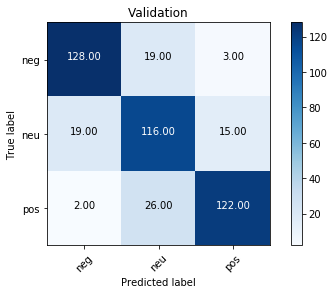

f1 score 0.8133333333333334


In [0]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
plot_confusion_matrix(cm_test,
                      ['neg', 'neu', 'pos'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))

Now we can predict completely made up adhoc examples:

In [0]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [0]:
predictions = getPrediction(pred_sentences)

Voila! We have a sentiment classifier!

In [0]:
predictions[0][2]